# Welcome to the Coral Model Testing and Exploration Notebook!

In this notebook, we take you through examples of running our model the various way to plot the model's outputs.

### We begin with loading the necessary libraries

In [1]:
from coralModelTracking import Organism, Reef, Ocean

import tools as tl
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colors as clt

from mpl_toolkits.axes_grid1.inset_locator import InsetPosition

### Next, we set out model parameters

In [24]:
## Simulations and Number of runs
NumberOfSimulations = 2
dt=.1
tf=100

## Grid shapes
rows, columns = 10, 10

## Inital Coral/Algae Percentages

coralPercent = .5
algaePercent = .25

## Parameters

r=1.0
d=.4 # vs .4 death rate (.2)
a=.2
g=.9
y=.75 # vs. .75 (.9)

threshold = 1.45 #extent of neighborhood recognition

NumberOfTimesteps = int(tf/dt)
NumberOfNodes = rows * columns
turfPercent = 1 - coralPercent - algaePercent

### Now we create and run multiple reefs

In [25]:
Pacific = Ocean()

for s in range(0,NumberOfSimulations):

    Moorea = Reef()
    count = 0
    for i in range(0,rows):        
        for j in range(0,columns):
            U = np.random.choice([0,1,2],
                                 p=[coralPercent, turfPercent, algaePercent])
            node = Organism(type=U, location=[i,j], ID=count)
            Moorea.append(node)
            count = count + 1
            
    Moorea.generateGraph(threshold)

    for n in range(0,NumberOfTimesteps):
        Moorea.roll(r=r, d=d, a=a, g=g, y=y, dt=dt) 
        
    Pacific.append(Moorea)

#### The Products we now can play with
* `Pacific.simulation[1].coralNodeCount`
* `Pacific.simulation[1].coralNeighborCount`

#### Functions to pull information from these objects

Can pull keys and values via:
- `x = list(dictionary.keys())`, and
- `y = list(dictionary.values())`

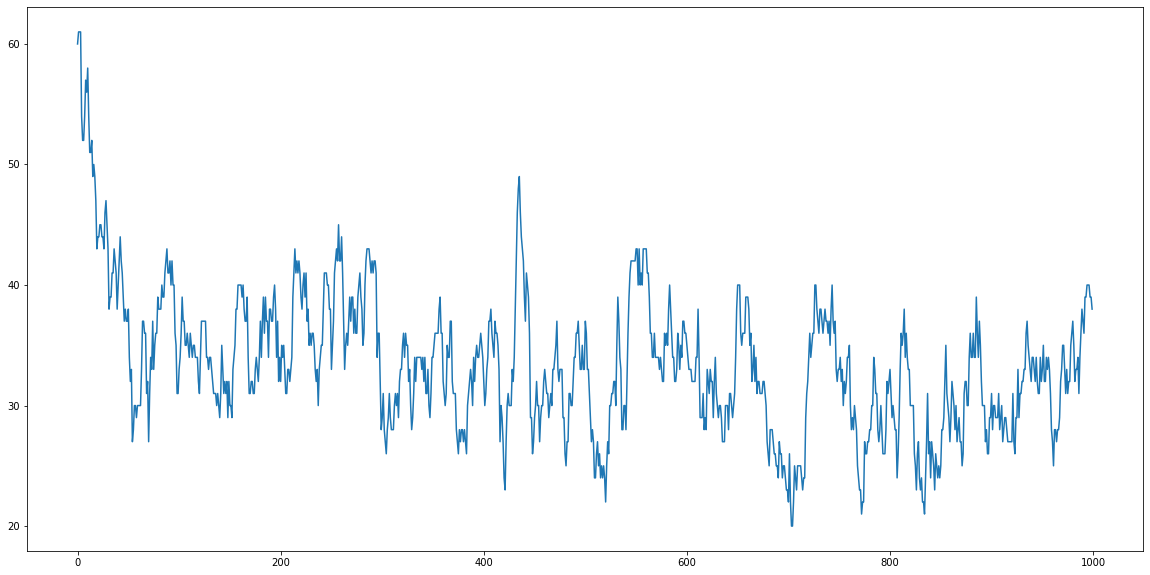

In [36]:
example = Pacific.simulation[1].coralNodeCount
x = list(example.keys())            ## the time steps
coralCount = list(example.values()) ## the number of coral nodes

plt.figure(figsize=(20, 10))
plt.plot(x,coralCount)

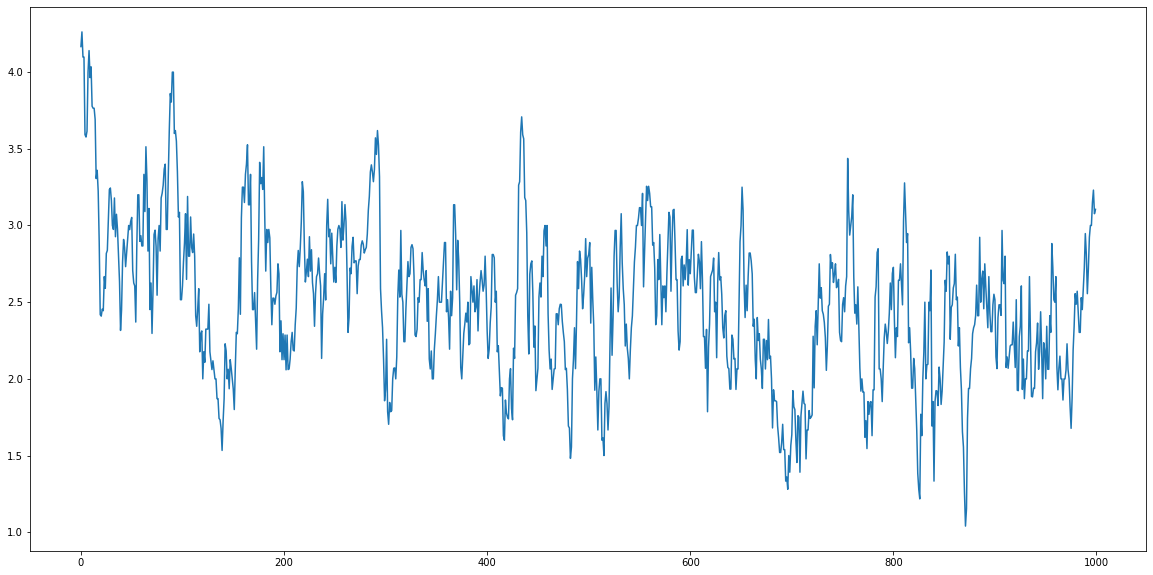

In [37]:
example = Pacific.simulation[1].coralNeighborCount
x = list(example.keys())
y = np.array(list(example.values()))/np.array(coralCount) ## taking the average of the neighborhood count

plt.figure(figsize=(20, 10))
plt.plot(x,y)

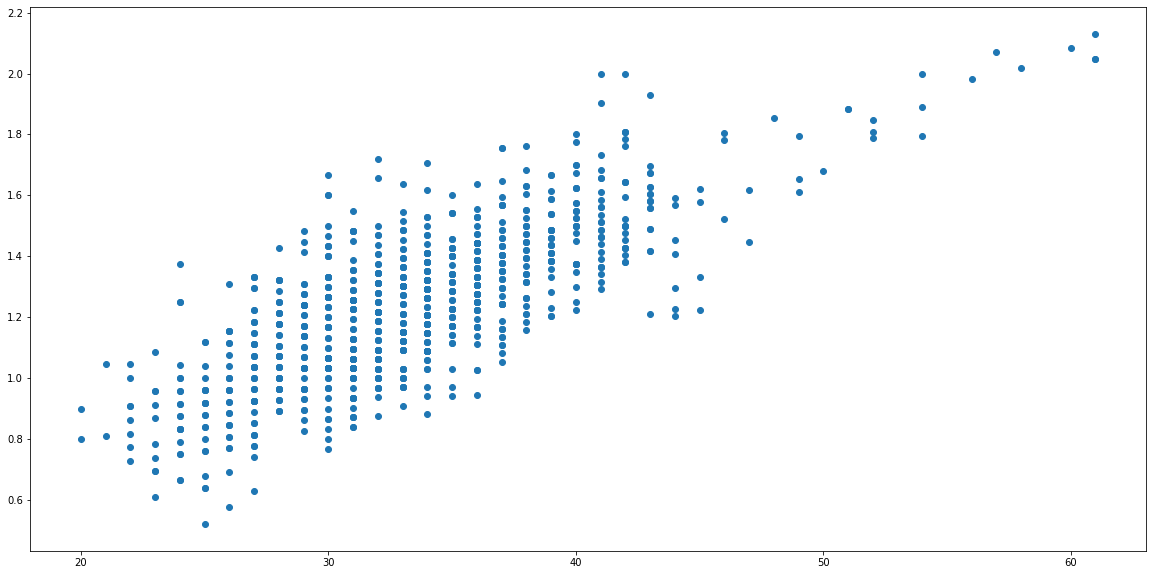

In [38]:
example = Pacific.simulation[1].coralNeighborCount
x = coralCount
y = np.array(list(example.values()))/np.array(coralCount)/2

plt.figure(figsize=(20, 10))
plt.scatter(x,y)